## Implement word2vec skip-gram model with NCE loss

The implementation of word2vec model is referred from [here](https://github.com/chiphuyen/stanford-tensorflow-tutorials/blob/master/examples/04_word2vec_visualize.py).

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
from tensorflow.contrib.tensorboard.plugins import projector
import tensorflow as tf
from IPython.display import Image

SCRIPT_DIR = os.path.dirname(os.path.abspath('__file__'))
PROJECT_DIR = os.path.dirname(SCRIPT_DIR)

import sys
sys.path.append(os.path.join(PROJECT_DIR, "python"))
import fin_w2v_utils

/Users/lifa08/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# model hyperparameters
VOCAB_SIZE = 5000
BATCH_SIZE = 128
SKIP_WINDOW = 1 # the context window

# Parameters for downloading data
DOWNLOAD_URL = 'http://statmt.org/wmt15/europarl-v8.fi.tgz'
EXPECTED_BYTES = 99540237
DATA_FILE_NAME = 'europarl-v8.fi.tgz'

DATA_DIR = os.path.join(PROJECT_DIR, 'data')
DATA_FILE_PATH = os.path.join(DATA_DIR, DATA_FILE_NAME)

VOCAB_DIR = os.path.join(PROJECT_DIR, 'vocab')
VOCAB_FILE_NAME = 'fin_vocab_' + str(VOCAB_SIZE) + '.tsv'
VOCAB_FILE_PATH = os.path.join(VOCAB_DIR, VOCAB_FILE_NAME)

INDEX_FILE = os.path.join(DATA_DIR, 'sentence_idx_imdb_' + str(VOCAB_SIZE) + '.pkl')
VISUAL_DIR = os.path.join(PROJECT_DIR, 'visualization/norm')

CHKPT_DIR = os.path.join(PROJECT_DIR, 'checkpoints/norm')
GRAPH_DIR = os.path.join(PROJECT_DIR, 'graphs/norm/lr_')

# Lemmatize or not
LEMMATIZE = False

Python **yield keyword** works like return, except the function will return a generator. More about generator from [here](https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do?page=1&tab=oldest#tab-top).

In [3]:
def gen():
    yield from fin_w2v_utils.batch_gen(DOWNLOAD_URL, DATA_DIR, DATA_FILE_PATH, EXPECTED_BYTES,
                                       VOCAB_DIR, VOCAB_FILE_PATH, VOCAB_SIZE, INDEX_FILE,
                                       BATCH_SIZE, SKIP_WINDOW, LEMMATIZE)

```tf.data.Dataset.from_generator``` creates a Dataset whose elements are generated by generator.

Good explanation of how does ```function tf.nn._embedding_lookup``` work from [here](https://stackoverflow.com/questions/34870614/what-does-tf-nn-embedding-lookup-function-do).

Good exlanation of NCE from [here](http://ruder.io/word-embeddings-softmax/index.html#negativesampling).

Good explanation of negative sampleing from [here](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/).

A good tutorial for string formatting in Python [here](https://www.digitalocean.com/community/tutorials/how-to-use-string-formatters-in-python-3).

In [4]:
class SkipGramModel:
    ''' Build the graph for word2vec model '''
    def __init__(self, dataset, vocab_size, embed_size, batch_size,
                 num_sampled, learning_rate, skip_step, chkpt_dir, graph_dir,
                 graph):
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self_batch_size = batch_size
        self.num_sampled = num_sampled
        self.lr = learning_rate
        self.skip_step = skip_step
        self.chkpt_dir = chkpt_dir
        self.graph_dir = graph_dir
        self.graph = graph

        with self.graph.as_default():
            self.global_step = tf.get_variable('global_step',
                                               initializer=tf.constant(0),
                                               trainable=False)
            self.dataset = dataset

    def _import_data(self):
        ''' Step 1: import data '''
        with tf.name_scope('data'):
            self.iterator = self.dataset.make_initializable_iterator()
            self.center_words, self.target_words=self.iterator.get_next()

    def _create_embedding(self):
        ''' Step 2 + 3: define weights and embedding lookup.
        In word2vec, it is actually the weights that we care about
        '''
        with tf.name_scope('embed'):
            self.embed_matrix = tf.get_variable('embed_matrix',
                                               shape=[self.vocab_size, self.embed_size],
                                               initializer=tf.random_uniform_initializer())
            # default range [0, 1] for float datatype fro tf.random_uniform_initializer
            self.embed = tf.nn.embedding_lookup(self.embed_matrix,
                                           self.center_words, name='embedding')

    def _create_loss(self):
        ''' Step 4: define the loss function '''
        with tf.name_scope('loss'):
            # construct variables for NCE loss
            # nce_weight and bias are the weights and biases for the last softmax layer
            nce_weight = tf.get_variable('nce_weight', 
                                        shape=[self.vocab_size, self.embed_size],
                                        initializer=tf.truncated_normal_initializer(
                                            stddev=1.0/(self.embed_size ** 0.5)))

            nce_bias = tf.get_variable('nce_bias', initializer=tf.zeros([self.vocab_size]))

            # define loss function to be NCE loss function
            self.loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weight,
                                                     biases=nce_bias,
                                                     labels=self.target_words,
                                                     inputs=self.embed,
                                                     num_sampled=self.num_sampled,
                                                     num_classes=self.vocab_size),
                                        name='loss')
    def _create_optimizer(self):
        ''' Step 5: define optimizer'''
        self.optimizer = tf.train.GradientDescentOptimizer(self.lr).minimize(self.loss,
                                                                             global_step=self.global_step)

    def _create_summaries(self):
        with tf.name_scope('summaries'):
            tf.summary.scalar('loss', self.loss)
            tf.summary.histogram('histogram_loss', self.loss)
            self.summary_op = tf.summary.merge_all()

    def build_graph(self):
        ''' Build the graph for our model '''
        with self.graph.as_default():
            self._import_data()
            self._create_embedding()
            self._create_loss()
            self._create_optimizer()
            self._create_summaries()

    def train(self, num_train_steps):
        # defaults to saving all variables - in this case embed_matrix, nce_weight, nce_bias
        with self.graph.as_default():
            saver = tf.train.Saver()

        initial_step = 0
        fin_w2v_utils.safe_mkdir(self.chkpt_dir)
        with tf.Session(graph=self.graph) as sess:
            sess.run(self.iterator.initializer)
            sess.run(tf.global_variables_initializer())
            ckpt = tf.train.get_checkpoint_state(self.chkpt_dir)

            # if that checkpoint exists, restore from checkporint
            if ckpt and ckpt.model_checkpoint_path:
                saver.restore(sess, ckpt.model_checkpoint_path)
                print('restoing from checkpoint')

            # we use this to calculate late average loss in the last SKIP_STEP steps
            total_loss = 0.0
            writer = tf.summary.FileWriter(self.graph_dir + str(self.lr), sess.graph)
            initial_step = self.global_step.eval()

            for index in range(initial_step, initial_step + num_train_steps):
                try:
                    loss_batch, _, summary = sess.run([self.loss,
                                                       self.optimizer,
                                                       self.summary_op])

                    # Need global step here so the model knows
                    # what summary corresponds to what step
                    writer.add_summary(summary, global_step=index)
                    total_loss += loss_batch

                    if (index + 1) % self.skip_step == 0:
                        print('Average loss at step {}:{:5.2f}'
                              .format(index, total_loss/self.skip_step))

                        total_loss = 0.0
                        saver.save(sess, self.chkpt_dir + '/skip-gram', index)

                except tf.errors.OutOfRangeError:
                    sess.run(self.iterator.initializer)

            writer.close()

    def visualize(self, vocab_file_path, visual_dir, num_visualize):
        ''' run tensorboad --logdir=visualization to see the embeddings '''

        # write the num_visualize most common words into file '/visual_dir/vocab_str(num_visualize)+.tsv'
        fin_w2v_utils.most_common_words(vocab_file_path, visual_dir, num_visualize)

        with self.graph.as_default():
            saver = tf.train.Saver()

        with tf.Session(graph=self.graph) as sess:
            sess.run(tf.global_variables_initializer())
            ckpt = tf.train.get_checkpoint_state(self.chkpt_dir)

            if ckpt and ckpt.model_checkpoint_path:
                saver.restore(sess, ckpt.model_checkpoint_path)

            final_embed_matrix = sess.run(self.embed_matrix)

            # you have to store embddings in a new variable
            embedding_var = tf.Variable(final_embed_matrix[:num_visualize], name='embedding')
            sess.run(embedding_var.initializer)

            config = projector.ProjectorConfig()
            summary_writer = tf.summary.FileWriter(visual_dir)

            # add embedding to the config file
            embedding = config.embeddings.add()
            embedding.tensor_name = embedding_var.name

            # link this tensor to its metadata file (labels), in this 
            # case the first NUM_VISUALIZE words of vocab
            embedding.metadata_path = 'vocab_' + str(num_visualize) + '.tsv'

            # saves a configuation file that TensorBoard with read during startup.
            projector.visualize_embeddings(summary_writer, config)
            saver_embed = tf.train.Saver([embedding_var])
            saver_embed.save(sess, os.path.join(visual_dir, 'model.ckpt'), 1)

Note that checkpoint information is stored at checkpoints directory;

visulization information is stored at visualization directory;

and summary information is stored at graphs/word2vec/lr1.0.

In [5]:
# Model hyperparameters
EMBED_SIZE = 128 # dimension of the word embedding vectors
NUM_SAMPLED = 64 # number of negative examples to sample
LEARNING_RATE = 1.0
SKIP_STEP = 1000

GRAPH = tf.Graph()

with GRAPH.as_default():
    dataset = tf.data.Dataset.from_generator(gen, (tf.int32, tf.int32), 
                                             (tf.TensorShape([BATCH_SIZE]),
                                              tf.TensorShape([BATCH_SIZE, 1])))

model = SkipGramModel(dataset, VOCAB_SIZE, EMBED_SIZE, BATCH_SIZE,
                      NUM_SAMPLED, LEARNING_RATE, SKIP_STEP, CHKPT_DIR,
                      GRAPH_DIR, GRAPH)

In [6]:
model.build_graph()

In [7]:
NUM_TRAIN_STEPS = 5000
model.train(NUM_TRAIN_STEPS)

INFO:tensorflow:Restoring parameters from /Users/lifa08/virtualenv/Codes/Word2vec_Fin/checkpoints/norm/skip-gram-64999
restoing from checkpoint
Average loss at step 65999: 3.94
Average loss at step 66999: 3.97
Average loss at step 67999: 3.94
Average loss at step 68999: 3.94
Average loss at step 69999: 3.95


## Visualize vector representation of anything

Use [TensorBoard: Embedding Projector](https://www.tensorflow.org/versions/r1.0/get_started/embedding_viz).

TensorBoard has a built-in visualizer, called the Embedding Projector, for interactive visualization and analysis of high-dimensional data like embeddings. The embedding projector will read the embeddings from your model checkpoint file.

By default, the Embedding Projector projects the high-dimensional data into **3** dimensions using **principal component analysis**.

Need to do **three** things in order to visualize embeddings:

1) Set up a 2D tensor to hold embedding.

```python
embedding_var = tf.Variable(..)
```

2) Save model variables in checkpoint periodically.

```python
saver.save(session, os.path.join(LOG_DIR, "model.ckpt"), step)
```

3) Associate metadata (labels) with embedding (optional).

```python
embedding.metadata_path = 
```

Metadata is **not a trainable parameter of the model, thus should be stored in a separate file** outside of the model checkpoint. The order in the metadata file is assumed to match the order in the embedding tensor.

A good article about visualizing representations is from [here](http://colah.github.io/posts/2015-01-Visualizing-Representations/).

In [8]:
NUM_VISUALIZE = 3000 # number of tokens to visualize
model.visualize(VOCAB_FILE_PATH, VISUAL_DIR, NUM_VISUALIZE)

INFO:tensorflow:Restoring parameters from /Users/lifa08/virtualenv/Codes/Word2vec_Fin/checkpoints/norm/skip-gram-69999


Then run ```./bin/tensorboard --logdir=Codes/Word2vec_Fin/visualization/norm``` and go to http://localhost:6006/.

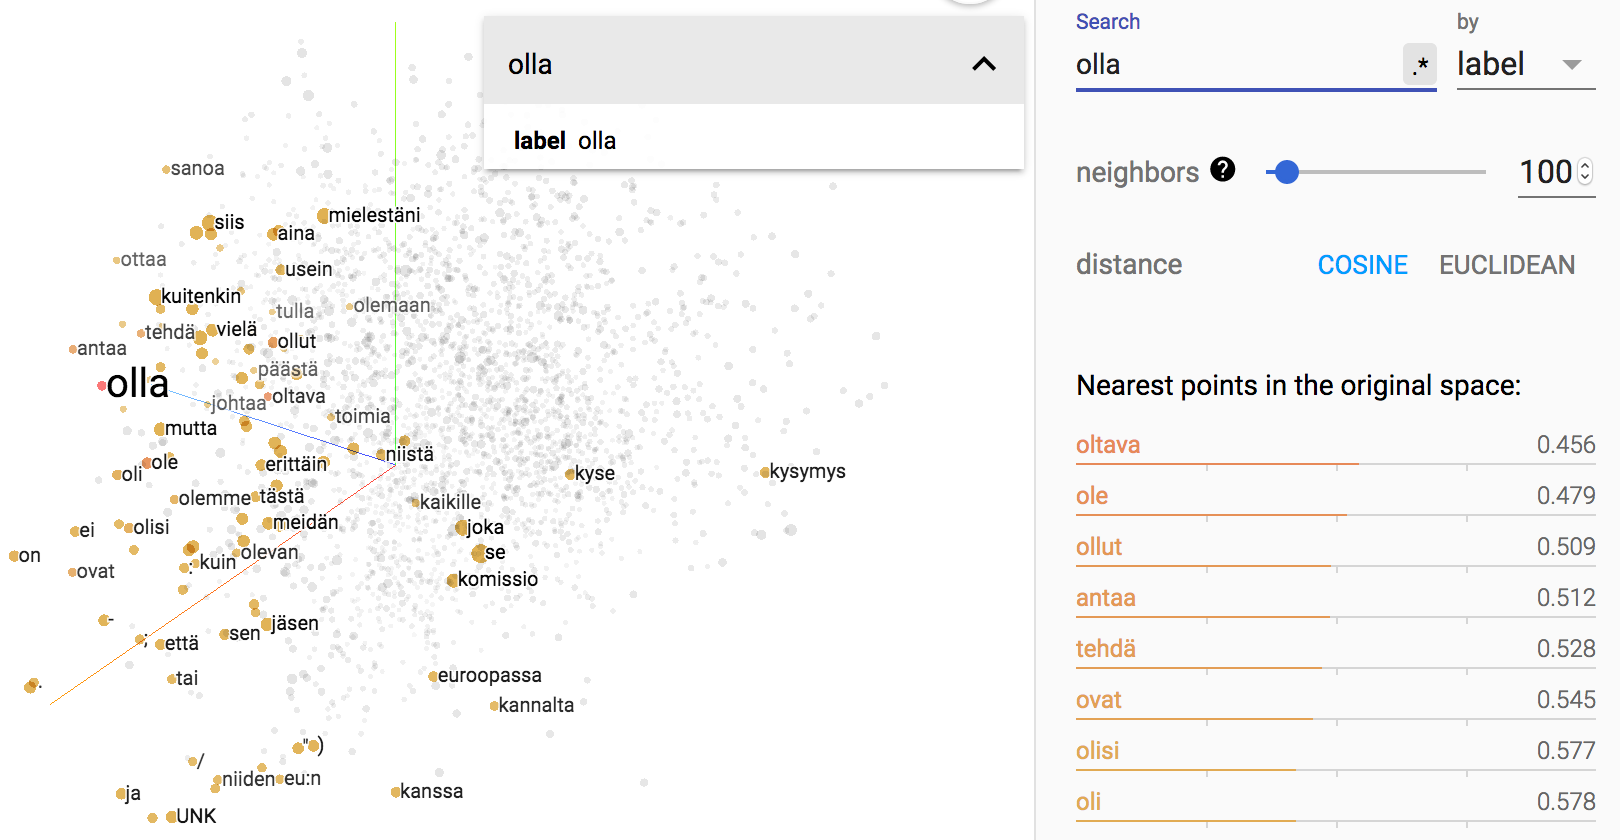

In [9]:
Image(filename='w2v_model.png')

## Lemmatization

The difference between stemming and lemmatization: https://blog.bitext.com/what-is-the-difference-between-stemming-and-lemmatization/

Sense2vec: https://explosion.ai/blog/sense2vec-with-spacy

Word2Vec with some Finnish NLP: https://swenotes.wordpress.com/2017/11/19/word2vec-with-some-finnish-nlp/

In [11]:
# model hyperparameters
VISUAL_DIR = os.path.join(PROJECT_DIR, 'visualization/lemmatized')
VOCAB_FILE_NAME = 'fin_vocab_' + str(VOCAB_SIZE) + '_lemmatized.tsv'
VOCAB_FILE_PATH = os.path.join(VOCAB_DIR, VOCAB_FILE_NAME)
INDEX_FILE = os.path.join(DATA_DIR, 'sentence_idx_imdb_' + str(VOCAB_SIZE) + '_lemmatized.pkl')
CHKPT_DIR = os.path.join(PROJECT_DIR, 'checkpoints/lemmatized')
GRAPH_DIR = os.path.join(PROJECT_DIR, 'graphs/lemmatized/lr_')

# Lemmatize or not
LEMMATIZE = True

GRAPH_LEMMATIZE = tf.Graph()

with GRAPH_LEMMATIZE.as_default():
    dataset = tf.data.Dataset.from_generator(gen, (tf.int32, tf.int32), 
                                             (tf.TensorShape([BATCH_SIZE]),
                                              tf.TensorShape([BATCH_SIZE, 1])))

model_lemmatized = SkipGramModel(dataset, VOCAB_SIZE,
                                 EMBED_SIZE, BATCH_SIZE, NUM_SAMPLED,
                                 LEARNING_RATE, SKIP_STEP, CHKPT_DIR,
                                 GRAPH_DIR, GRAPH_LEMMATIZE)

In [12]:
model_lemmatized.build_graph()

In [13]:
NUM_TRAIN_STEPS = 5000
model_lemmatized.train(NUM_TRAIN_STEPS)

INFO:tensorflow:Restoring parameters from /Users/lifa08/virtualenv/Codes/Word2vec_Fin/checkpoints/lemmatized/skip-gram-49999
restoing from checkpoint
Average loss at step 50999: 4.38
Average loss at step 51999: 4.41
Average loss at step 52999: 4.39
Average loss at step 53999: 4.38
Average loss at step 54999: 4.39


In [14]:
model_lemmatized.visualize(VOCAB_FILE_PATH, VISUAL_DIR, NUM_VISUALIZE)

INFO:tensorflow:Restoring parameters from /Users/lifa08/virtualenv/Codes/Word2vec_Fin/checkpoints/lemmatized/skip-gram-54999


## Putting all of above into file fin_word2vec.py

```python fin_word2vec.py -l True```

**Note: ** remember to activate the virtual environment with ```source ./bin/activate``` first.

In [15]:
! python ../python/fin_word2vec.py -h

usage: fin_word2vec.py [-h] [-l LEMMATIZE]

Train a word2vec model using Finnish text

optional arguments:
  -h, --help            show this help message and exit
  -l LEMMATIZE, --lemmatize LEMMATIZE
                        lemmatize the text or not (default: False, not
                        lemmatizing)


In [16]:
! source ../../../bin/activate && ! python ../python/fin_word2vec.py

/Users/lifa08/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
restoing from checkpoint
Average loss at step 70999: 3.88
Average loss at step 71999: 3.92
Average loss at step 72999: 3.89
Average loss at step 73999: 3.89
Average loss at step 74999: 3.91
Average loss at step 75999: 3.99
Average loss at step 76999: 3.99
Average loss at step 77999: 4.00
Average loss at step 78999: 3.98
Average loss at step 79999: 3.98
Average loss at step 80999: 3.98
Average loss at step 81999: 3.97
Average loss at step 82999: 3.96
Average loss at step 83999: 3.97
Average loss at step 84999: 3.98
Average loss at step 85999: 3.96
Average loss at step 86999: 3.95
Average loss at step 87999: 3.93
Average loss at step 88999: 3.95
Average loss at step 89999: 3.9